In [1]:
import numpy as np
import pandas as pd
import random
import os
import skimage.io
from IPython.display import clear_output
from skimage.transform import resize, rescale
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [5]:
data, attrs = fetch_dataset()

In [6]:
#Разобьем дата сет
batch_size = 32

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)
print("Training input shape: ", train_photos.shape)

data_tr = torch.utils.data.DataLoader(train_photos, batch_size=batch_size)
data_val = torch.utils.data.DataLoader(val_photos, batch_size=batch_size)

Training input shape:  (11828, 64, 64, 3)


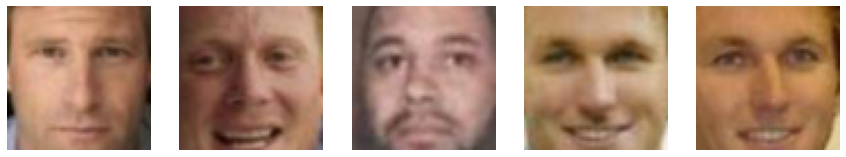

In [8]:
plt.figure(figsize=(18, 6))
for i in range(5):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])
plt.show()

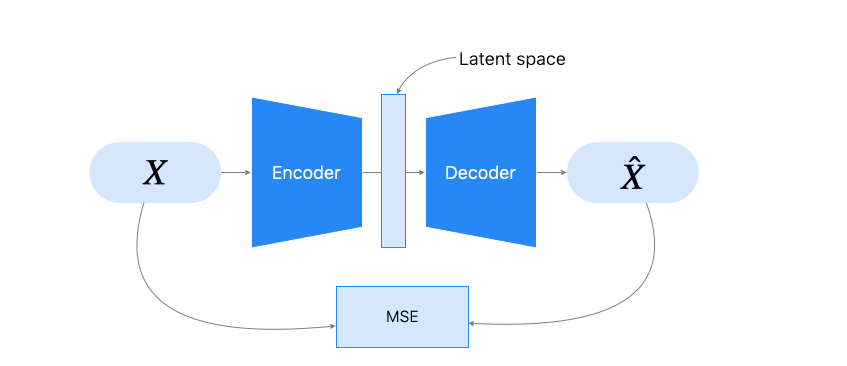

In [9]:
#латьентный вектор
dim_code = 64

In [10]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            )
      
        self.fc = nn.Sequential(
            nn.Linear(16 * 64 * 3, dim_code)
        )
        self.unfc = nn.Sequential(
            nn.Linear(dim_code, 16 * 64 * 3),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 128, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=7, stride=1, padding=3),
            )
              
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        latent_code = self.fc(x)
        x = self.unfc(latent_code).view(-1, 16, 64, 3)
        reconstruction = self.decoder(x)
        
        return reconstruction, latent_code

In [11]:
criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


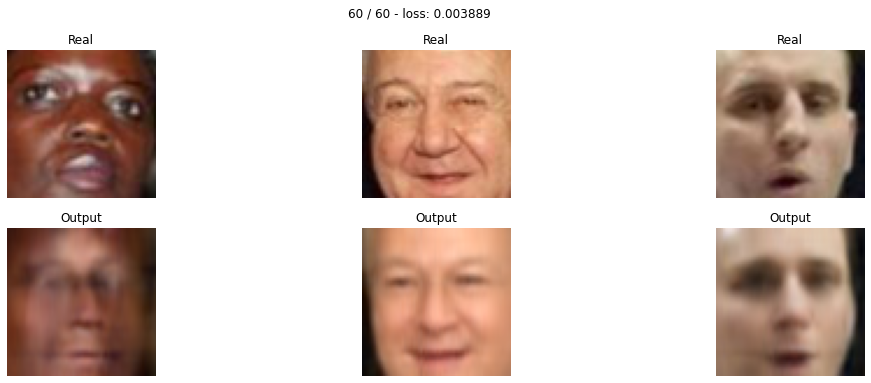

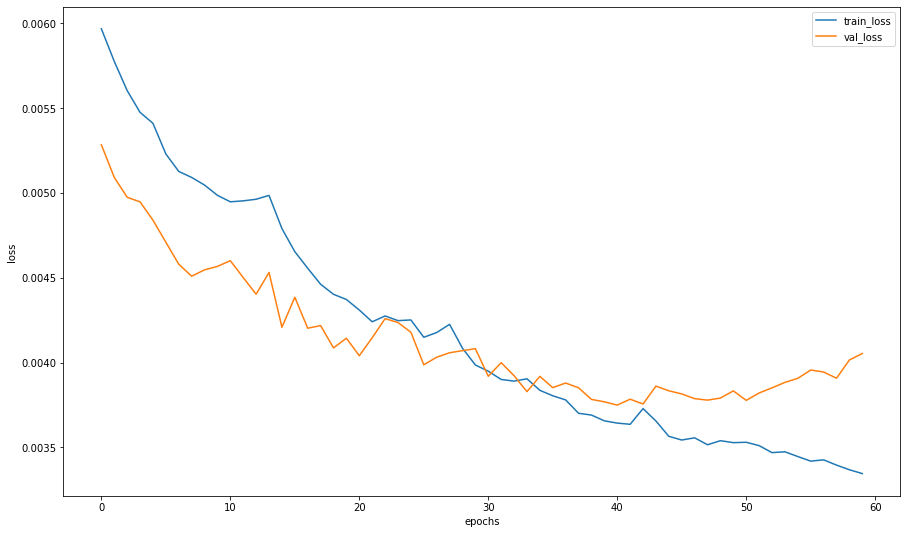

In [15]:
n_epochs = 60
train_losses = []
val_losses = []
latents = torch.Tensor()
truth = torch.Tensor()
pred = torch.Tensor()

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(data_tr):
        optimizer.zero_grad()
        reconstructed, latent_image = autoencoder(X_batch.to(device))
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in data_val:
            reconstructed, latent_image = autoencoder(X_batch.to(device))
            loss = criterion(reconstructed, X_batch.to(device))
            val_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                truth = torch.cat((truth, X_batch), 0)
                latents = torch.cat((latents, latent_image.to('cpu')), 0)
                pred = torch.cat((pred, reconstructed.to('cpu')), 0)

    val_losses.append(np.mean(val_losses_per_epoch))

    # Visualize tools
    plt.figure(figsize=(18, 6))
    clear_output(wait=True)
    for k in range(3):
        plt.subplot(2, 3, k+1)
        plt.imshow(X_batch[k].cpu())
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 3, k+4)
        plt.imshow(reconstructed[k].cpu())
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, loss.item()))
    plt.show()

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


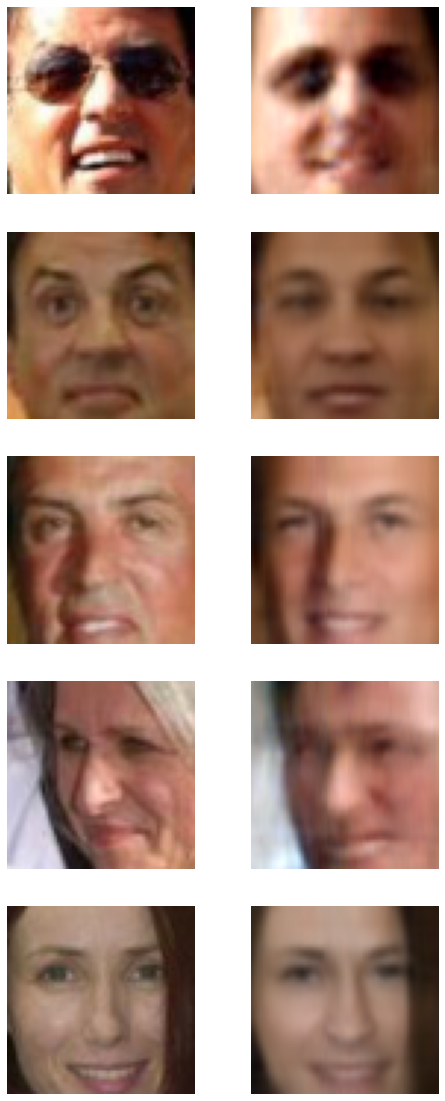

In [16]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(truth[:5], pred[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(res)

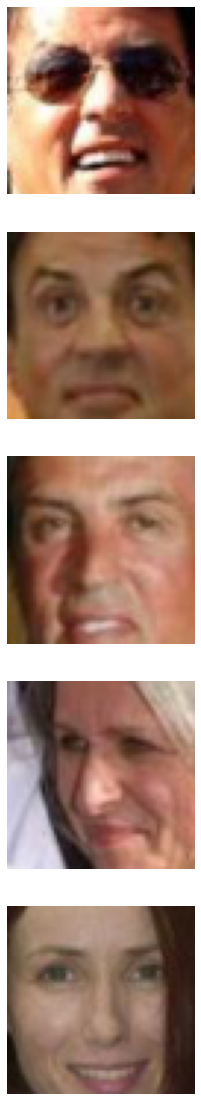

In [26]:
plt.figure(figsize=(8, 20))
for i, gt in enumerate(truth[:5]):
    plt.subplot(5, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(gt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


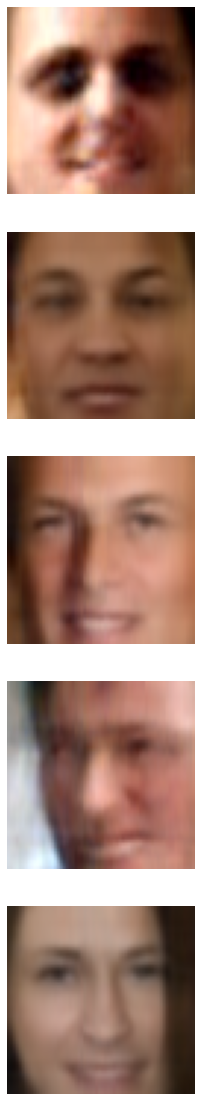

In [29]:
plt.figure(figsize=(8, 20))
for i, res in enumerate(pred[:5]):
    plt.subplot(5, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(res)